# Chapter 7
> FastBook Chapter 7 Training a State-of-the-Art Model, this chapter is a bit different, it  contains some technics that make the results better. My plan is taking some notes about this practical technics and come back later when I need them.
- toc: true 
- badges: true
- comments: true
- categories: [fastbook]
- image: images/fastbook_images/chapter-07/taner_ceylan.png

![](images/chapter-07/taner_ceylan.png)
This my favorite Turkish coffe cup, designed by German-Turkish artist Taner Ceylan, check his works at [here](https://www.tanerceylan.com)

In [19]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
%config Completer.use_jedi = False

## Imagenette

`Imagenette` is a subset of `ImageNet` that contains 10 classes from the full ImageNet that looked very different from one another. Considering the size of ImageNet, it is very costly and time consuming to create a prototype for your project. Smaller datasets lets you make much more experiments, and could provide insight for your projects direction. 

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [4]:
dblock = DataBlock(blocks = (ImageBlock(),CategoryBlock()),
                    get_items=get_image_files,
                    get_y=parent_label,
                    item_tfms=Resize(460),
                    batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path,bs=64)

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [5]:
model=xresnet50(n_out=dls.c)
learn=Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy)
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.581075,3.990604,0.335325,01:11
1,1.188324,2.071529,0.488798,01:12
2,0.967764,1.166690,0.639656,01:12
3,0.723403,0.728145,0.770724,01:12
4,0.571699,0.579214,0.828603,01:12


/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Normalization

Normalized data helps better results. Normalization is your data has a mean of 0 and standart deviation of 1. But our data encoded with numbers between 0 and 255 or sometimes 0-1. Lets check the data in the Imaginette:

In [6]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4661, 0.4575, 0.4309], device='cuda:0'),
 TensorImage([0.2791, 0.2752, 0.2898], device='cuda:0'))

Our data is around 0.5 mean and 0.3 deviation. So it is not in desirable range.With fastai it is possible to normalize our data by adding `Normalize` transform.

In [7]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [8]:
dls = get_dls(64, 224)

In [9]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.2460, -0.1802, -0.0632], device='cuda:0'),
 TensorImage([1.2249, 1.1904, 1.2784], device='cuda:0'))

Now it is better. Let's check it if it helped the training process. Same code again for the training.

In [10]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.612493,2.099523,0.436146,01:12
1,1.253520,1.564609,0.538462,01:12
2,0.957898,1.758915,0.567961,01:14
3,0.760550,0.672671,0.788648,01:14
4,0.613525,0.580995,0.819268,01:13


a little bit better but `Normalization` is much more important when we use pretrained model. Normalizing our data with the original data statistic helps better transfer learning results.

## Progressive Resizing

from the book:

 Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher. We call this approach progressive resizing.

### This my check on using progressive resizing

In [11]:
import time
start_time = time.time()
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.628276,3.793727,0.295370,00:35
1,1.250497,1.006853,0.675878,00:36
2,0.945165,0.896517,0.711352,00:35
3,0.750154,0.655099,0.798730,00:35


In [12]:
learn.dls = get_dls(64, 224)
learn.fine_tune(6, 3e-3)
print("--- %s seconds ---" % (time.time() - start_time))

epoch,train_loss,valid_loss,accuracy,time
0,1.072026,1.799888,0.481703,01:11


epoch,train_loss,valid_loss,accuracy,time
0,0.740281,0.882515,0.753174,01:11
1,0.772105,0.909184,0.714339,01:11
2,0.671060,0.985478,0.727035,01:11
3,0.588883,0.552914,0.830471,01:11
4,0.464459,0.420264,0.870052,01:13
5,0.404156,0.390893,0.877147,01:12


--- 649.6742904186249 seconds ---


In [14]:
import time
start_time = time.time()
dls = get_dls(32, 224)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(8, 3e-3)
print("--- %s seconds ---" % (time.time() - start_time))

epoch,train_loss,valid_loss,accuracy,time
0,1.662178,1.874999,0.467886,01:22
1,1.307072,1.275218,0.576176,01:23
2,1.070854,1.173411,0.638536,01:23
3,0.842672,0.831104,0.728902,01:23
4,0.699521,0.746880,0.774832,01:24
5,0.579603,0.524914,0.828603,01:23
6,0.457707,0.423468,0.868559,01:24
7,0.401849,0.415911,0.872293,01:23


--- 670.1757352352142 seconds ---


I've changed some hyperparameters like number of epochs and learning rate. It is faster and  better result most of the time(not in every situation), nice.

## Test Time Augmentation

Random cropping sometimes leads suprising problems.Especially if it used with multicategory images, for example  the objects in the image that close to edges could be ignored totaly. There are some workarounds to solve this problem (squish or stretch them)but most of them couse other kind of problems that could hurt the results. Only downside is validation time would be slower.

> Warning: How is it possible? Since we do not use validation loss for backpropagation how come it improves our results.

In [16]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8760268688201904

from the book:

jargon: test time augmentation (TTA): During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

## Mixup

Especially used when we don't have enough data and do not have pretrained model that was trained on similar to our dataset.

from the book:
Mixup works as follows, for each image:

1. Select another image from your dataset at random.
1. Pick a weight at random.
1. Take a weighted average (using the weight from step 2) of the selected image with your image; this will be your independent variable.
1. Take a weighted average (with the same weight) of this image's labels with your image's labels; this will be your dependent variable.

The paper explains: "While data augmentation consistently leads to improved generalization, the procedure is dataset-dependent, and thus requires the use of expert knowledge." For instance, it's common to flip images as part of data augmentation, but should you flip only horizontally, or also vertically? The answer is that it depends on your dataset. In addition, if flipping (for instance) doesn't provide enough data augmentation for you, you can't "flip more." It's helpful to have data augmentation techniques where you can "dial up" or "dial down" the amount of change, to see what works best for you.

shows what it looks like when we take a linear combination of images, as done in Mixup.

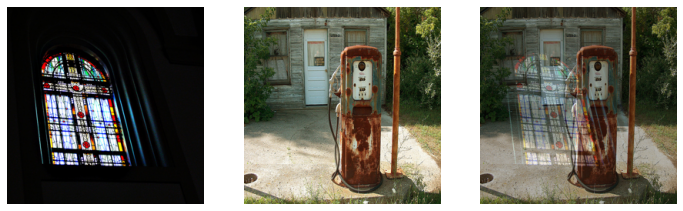

In [18]:
#hide_input
#id mixup_example
#caption Mixing a church and a gas station
#alt An image of a church, a gas station and the two mixed up.
church = PILImage.create(get_image_files(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files(path/'train'/'n03425413')[0])
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas), ax=axs[2]);

I've replaced these rows like above. It seems there is no ``get_image_files_sorted`` method in the fastai.
```python
church = PILImage.create(get_image_files_sorted(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files_sorted(path/'train'/'n03425413')[0])
```

## Label Smoothing

> Warning: check the original notebook for this part. Only thing I can say is, it used for making the model less confident for the classification to overcome overfitting.